In [1]:
import copy
import numpy as np
import os
import verdict
import sys

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as plt_lines

In [3]:
import galaxy_dive.read_data.metafile as read_metafile
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers

In [4]:
import linefinder.utils.file_management as file_management
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.worldlines as worldlines
import linefinder.utils.presentation_constants as p_constants
import linefinder.config as l_config

In [5]:
import analysis_config

# Load Data

In [6]:
do_calculation = False

In [7]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 465, galdef 


In [8]:
presentation_figure = False

In [9]:
mass_key = 'M'

In [10]:
save_file_tags = {
    'M' : 'mass',
    'metal_mass' : 'metalmass',
    'enriched_metal_mass' : 'enrichedmetalmass',
}

In [11]:
axes_labels = {
    'M' : 'Mass',
    'metal_mass' : 'Metal Mass',
    'enriched_metal_mass' : 'Metal Mass',
}

In [12]:
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
ind = 600 - snum

In [14]:
tag_tail = '_CGM_snum{}'.format( snum )

In [15]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail,
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)
defaults, variations

({'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
  'tag': 'm12i_CGM_snum465',
  'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
  'ahf_index': 600,
  'main_halo_id': 0},
 {'m10q': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10q_res250/data',
   'tag': 'm10q_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10q_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 0},
  'm10v': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10v_res250/data',
   'tag': 'm10v_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10v_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 2},
  'm10y': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10y_res250/data',
   'tag': 'm10y_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10y_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 0},
  'm10z': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10z_res250/data',
   'tag': 'm10z_C

In [16]:
w_set = worldline_set.WorldlineSet( defaults, variations )

In [17]:
default_sim_name = list( w_set.keys() )[0]

In [18]:
w = w_set[default_sim_name]

In [19]:
classifications = copy.deepcopy( p_constants.CLASSIFICATIONS_CGM_FATE )
classifications.append( 'is_in_CGM_not_sat' )
classifications.append( 'is_CGM_fate_unclassified' )
classifications += p_constants.CLASSIFICATIONS_LOCATION

In [20]:
metafile_reader = read_metafile.MetafileReader(
    file_manager.get_metafile_dir( default_sim_name )
)

# Analyze Data

### Get masses out

#### Mass Fractions

In [21]:
def choose_slice( classification ):
        
    if classification in p_constants.CLASSIFICATIONS_LOCATION:
        i_ind = 0
    else:
        i_ind = ind
        
    return ( slice(None), i_ind )

In [22]:
if do_calculation:
    
    CGM_selection = 'is_in_CGM'
#     CGM_selection = 'is_in_CGM_not_sat'
    
    CGM_mass_fractions_fate = {}
    CGM_mass_fractions_joint = {}

    for sim_name in w_set.keys():
        
        print( sim_name )
        
        w = w_set[sim_name].data_object
        
        # Make temperature masks
        w.data_masker.mask_data(
            'T',
            0.,
            10.**5.3,
            optional_mask = True,
            mask_name = 'cool',
        )
        w.data_masker.mask_data(
            'T',
            10.**5.3,
            np.inf,
            optional_mask = True,
            mask_name = 'hot',
        )
        optional_masks = {
            'all': None,
            'cool': [ 'cool', ],
            'hot': [ 'hot', ],
        }
        
        for temp_cut in [ 'all', 'cool', 'hot' ]:
            try:
                CGM_mass_fractions_fate[temp_cut]
                CGM_mass_fractions_joint[temp_cut]
            except KeyError:
                CGM_mass_fractions_fate[temp_cut] = {}
                CGM_mass_fractions_joint[temp_cut] = {}

            normalization_mass = w.get_selected_quantity(
                selection_routine = CGM_selection,
                ptype = 'gas',
                sl = (slice(None),ind),
                selected_quantity_data_key = mass_key,
#                 optional_masks = optional_masks[temp_cut],
            )

            # See what different fates consist of
            for classification in classifications:
                
                # Choose what gas to select
                if classification in p_constants.CLASSIFICATIONS_LOCATION:
                    c_selection_routine = classification
                else:
                    c_selection_routine = [ classification, CGM_selection ]

                # Get mass fraction
                mass = w.get_selected_quantity(
                    selection_routine = c_selection_routine,
                    ptype = 'gas',
                    sl = choose_slice( classification ),
                    selected_quantity_data_key = mass_key,
                    optional_masks = optional_masks[temp_cut],
                )
                try:
                    mass_frac = mass / normalization_mass
                except ZeroDivisionError:
                    np.testing.assert_allclose( mass, 0. )
                    mass_frac = 0.0

                # Store the data
                try:
                    CGM_mass_fractions_fate[temp_cut][classification]
                    CGM_mass_fractions_joint[temp_cut][classification]
                except KeyError:
                    CGM_mass_fractions_fate[temp_cut][classification] = verdict.Dict( {} )
                    CGM_mass_fractions_joint[temp_cut][classification] = verdict.Dict( {} )
                CGM_mass_fractions_fate[temp_cut][classification][sim_name] = mass_frac

                # Look at relationship between origin and fate
                inner_classifications = (
                    p_constants.CLASSIFICATIONS_CGM_ORIGIN +
                    p_constants.CLASSIFICATIONS_LOCATION
                )
                for i_c in p_constants.CLASSIFICATIONS_CGM_ORIGIN:
                    
                                    
                # Choose what gas to select
                    if i_c in p_constants.CLASSIFICATIONS_LOCATION:
                        i_c_selection_routine = [ classification, i_c, ]
                    else:
                        i_c_selection_routine = [ classification, i_c, CGM_selection ]

                    # Get mass fraction
                    mass = w.get_selected_quantity(
                        selection_routine = [ classification, i_c, CGM_selection ],
                        ptype = 'gas',
                        sl = choose_slice( classification ),
                        selected_quantity_data_key = mass_key,
                        optional_masks = optional_masks[temp_cut],
                    )
                    try:
                        mass_frac = mass / normalization_mass
                    except ZeroDivisionError:
                        np.testing.assert_allclose( mass, 0. )
                        mass_frac = 0.0

                    # Store the data
                    try:
                        CGM_mass_fractions_joint[temp_cut][classification][i_c]
                    except KeyError:
                        CGM_mass_fractions_joint[temp_cut][classification][i_c] = verdict.Dict( {} )
                    CGM_mass_fractions_joint[temp_cut][classification][i_c][sim_name] = mass_frac

        w.clear_data()

In [23]:
if do_calculation:
    # Wrap up
    CGM_mass_fractions = {}
    CGM_mass_fractions['fate'] = CGM_mass_fractions_fate
    CGM_mass_fractions['joint'] = CGM_mass_fractions_joint
    CGM_mass_fractions = verdict.Dict( CGM_mass_fractions )

#### Halo Masses

In [24]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )

#### Save and load results

In [25]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_{}_frac_snum{}.hdf5'.format( save_file_tags[mass_key], snum ),
)

In [26]:
if do_calculation:

    # Format results to save
    results_to_save = copy.deepcopy( CGM_mass_fractions )
    results_to_save['m_vir'] = halo_masses

    results_to_save.to_hdf5(
        savefile, 
        condensed = True, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

In [27]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )
    
    halo_masses = results_to_load['m_vir']
    CGM_mass_fractions = copy.deepcopy( results_to_load )
    del CGM_mass_fractions['m_vir']
    
    redshift = attributes['redshift']

# Plot Data

## Setup

In [28]:
mass_range = [ halo_masses.array().min()/1.5, halo_masses.array().max()*1.5 ]
mass_range

[4999857549.857551, 2233547008547.009]

In [29]:
m_vir_md_split = halo_masses.split_by_key_slice( slice(4,10), '_md' )
m_vir_fiducials = m_vir_md_split[False]
m_vir_mds = m_vir_md_split[True]

In [30]:
def save_plot_stage( fig, base_save_file, index ):

    save_file = '{}.{}.pdf'.format( base_save_file, index )
    
    plotting.save_fig(
        out_dir = file_manager.get_project_presentation_dir(),
        save_file = save_file,
        fig = fig,
    )
    
    return index + 1

## Mass Fraction Plot

## Fiducial

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/CGM_mass_frac_vs_Mh_CGM_snum465.pdf


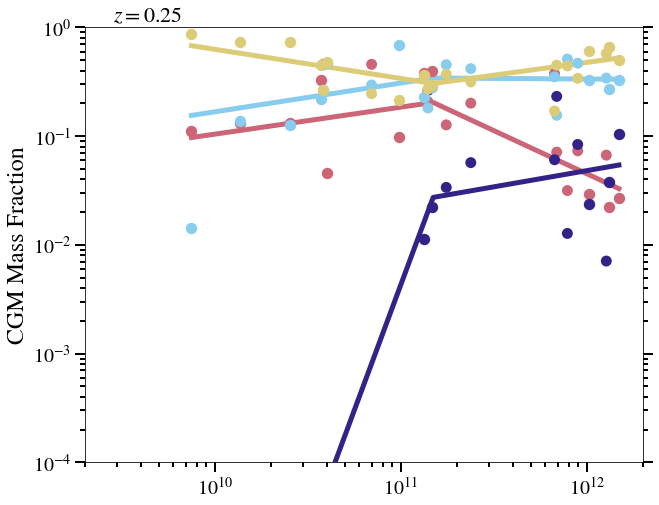

In [31]:
fig = plt.figure( figsize=(10,8), facecolor='w' )
ax = plt.gca()

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
        continue
        
    item = CGM_mass_fractions['fate']['all'][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
        
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
    # Box plot
    if mass_key != 'M':
        x_data_list = [ m_vir_fiducials, m_vir_mds, ]
        y_data_list = [ fiducials, mds, ]
        linestyles = [ '-', '--', ]
    else:
        x_data_list = [ halo_masses, ]
        y_data_list = [ item, ]
        linestyles = [ '-', ]
    for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 5,
            linestyle = linestyle,
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
        )
    
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    # Add a redshift label
    if k == 0:
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

    if snum == 172:
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( y_min, y_max )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )
    
    # Add ticks to the righ
    ax.yaxis.set_ticks_position( 'both' )

    if snum == 172:
        legend = ax.legend(
            color_objects,
            labels,
            prop={'size': 17.5},
            ncol=1,
            loc='lower right',
            fontsize=24,
            framealpha = 0.8,
        )
        legend.set_zorder( 120 )

save_file = 'CGM_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

## Temperature Dependent

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/CGM_mass_frac_vs_Mh_CGM_snum465.pdf


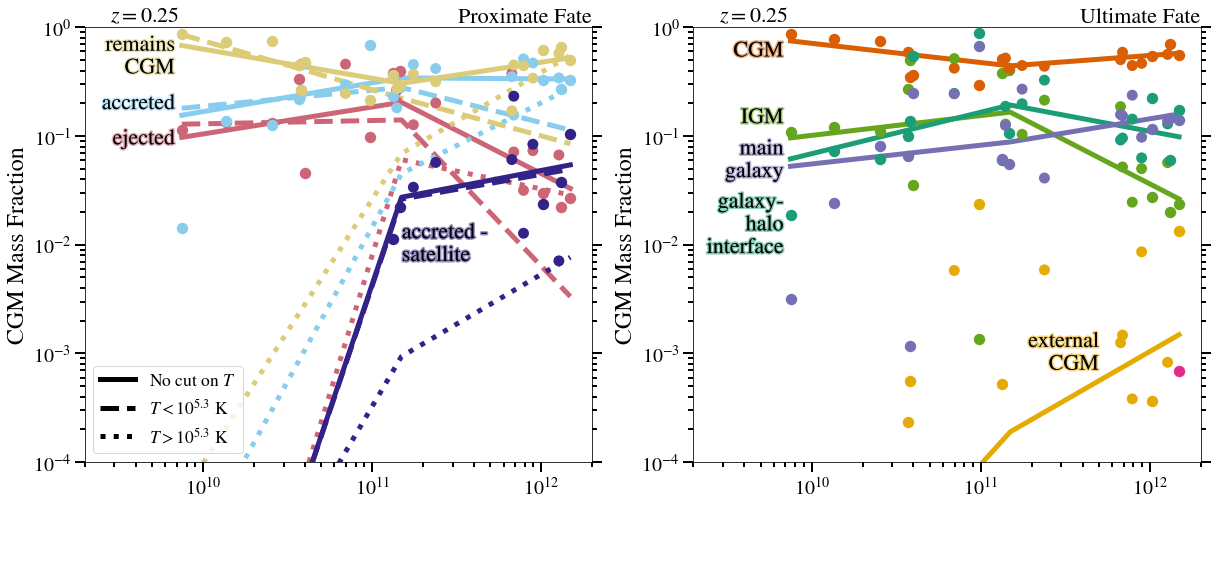

In [32]:
fig = plt.figure( figsize=(20,8), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 1, 2, )
gs.update( hspace=0.00001 )

ax = plt.subplot( gs[0,0] )

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
        continue
        
    fid_linestyle = {
        'all': '-',
        'cool': '--',
        'hot': ':',
    }
    fid_marker = {
        'all': 'o',
        'cool': 6,
        'hot': 7,
    }
    
    for t_cut in [ 'all', 'cool', 'hot' ]:
        item = CGM_mass_fractions['fate'][t_cut][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        if t_cut == 'all':

            # Default points
            ax.scatter(
                m_vir_fiducials.array(),
                fiducials.array(),
                marker=fid_marker[t_cut],
                s = 130,
                color = None,
                zorder = 100 - k,
                linewidth = 0,
                facecolors = l_config.COLORSCHEME[classification],
                alpha = alpha,
            )

            if mass_key != 'M':
                facecolors = 'none'
                color = edgecolor
            else:
                facecolors = l_config.COLORSCHEME[classification]
                color = 'none'

            # Turbulent metal diffusion
            ax.scatter(
                m_vir_mds.array(),
                mds.array(),
                marker=fid_marker[t_cut],
                s = 120,
                color = color,
                zorder = 100 - k,
                facecolors = facecolors,
                linewidth = 3.5,
                alpha = alpha,
            )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ fid_linestyle[t_cut], ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            means = plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
                return_means = True,
            )
        
        if t_cut == 'all':
            
            ################################################################################
            # Annotate lines   

            # Default args
            if snum == 465:
                xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
                ha = 'right'
            elif snum == 172:
                xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
                ha = 'left'
            label_args = {
                's' : p_constants.CLASSIFICATION_LABELS[classification],
                'xy' : xy,
                'fontsize' : 22,
                'color' : 'k',
                'va': 'center',
                'ha': ha,
            }

            # Customization
            if classification == 'is_in_main_gal':
                label_args['s'] = 'main\ngalaxy'
                if snum == 465:
                    label_args['xy'][1] *= 0.9
                elif snum == 172:
                    label_args['xy'][1] *= 1.2
            elif classification == 'is_in_galaxy_halo_interface':
                label_args['s'] = 'galaxy-\nhalo\ninterface'
                if snum == 465:
                    label_args['xy'][1] *= 0.15
                elif snum == 172:
                    label_args['xy'][1] *= 0.5
            elif classification == 'is_in_IGM' and snum == 465:
                    label_args['xy'][1] *= 1.2
            elif classification == 'is_in_other_CGM_not_main':
                label_args['s'] = 'external\nCGM'
                if snum == 465:
                    label_args['xy'] = [ 5e11, 1e-3 ]
            elif classification == 'is_CGM_accreted' and snum == 465:
                label_args['xy'][1] *= 0.9
            elif classification == 'is_CGM_accreted_to_satellite':
                label_args['s'] = 'accreted -\nsatellite'
                if snum == 465:
                    label_args['xy'] = [ 1.5*1e11, 1e-2 ]
                    label_args['ha'] = 'left'
            elif classification == 'is_CGM_still':
                label_args['s'] = 'remains\nCGM'
                if snum == 465:
                    label_args['xy'][1] *= 1.1
            elif classification == 'is_CGM_ejected' and snum == 465:
                label_args['xy'][1] *= 0.7

            text = ax.annotate( **label_args )

            text.set_path_effects([
                path_effects.Stroke(
                    linewidth=3, 
                    foreground=l_config.COLORSCHEME[classification],
                    alpha = 0.5,
                ),
                path_effects.Normal(),
            ])
    
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                         
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

# Add a redshift label
redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

if snum == 172:
    ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

ax.set_xlim( 2e9, 2e12 )
ax.set_ylim( y_min, y_max )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

# Add ticks to the righ
ax.yaxis.set_ticks_position( 'both' )

ax.annotate(
    s = 'Proximate Fate',
    xy = ( 1., 1. ),
    va = 'bottom',
    ha = 'right',
    xycoords = 'axes fraction',
    fontsize = 22,
)
    
## Add Temperature labels
t_cuts = [ 'all', 'cool', 'hot' ]
legend_objects = []
for t_cut in t_cuts:
    legend_objects.append( plt_lines.Line2D(
        [0], 
        [0], 
        color='k',
        lw=5,
        linestyle=fid_linestyle[t_cut]
    ) )
legend_labels = [ r'No cut on $T$', r'$T < 10^{5.3}$ K', r'$T > 10^{5.3}$ K' ]
legend = ax.legend(
    legend_objects,
    legend_labels,
    prop={'size': 17.5},
    ncol=1,
    loc='lower left',
    fontsize=24,
    framealpha = 0.8,
)
legend.set_zorder( 120 )



fig

ax = plt.subplot( gs[0,1] )

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_LOCATION ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
        
    t_cut = 'all'
        
    item = CGM_mass_fractions['fate'][t_cut][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
        
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
    # Box plot
    if mass_key != 'M':
        x_data_list = [ m_vir_fiducials, m_vir_mds, ]
        y_data_list = [ fiducials, mds, ]
        linestyles = [ '-', '--', ]
    else:
        x_data_list = [ halo_masses, ]
        y_data_list = [ item, ]
        linestyles = [ '-', ]
    for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        means = plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 5,
            linestyle = linestyle,
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
            return_means = True,
        )
    
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
        
        ## Annotate lines   
        
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_in_main_gal':
            label_args['s'] = 'main\ngalaxy'
            if snum == 465:
                label_args['xy'][1] *= 0.9
            elif snum == 172:
                label_args['xy'][1] *= 1.2
        elif classification == 'is_in_galaxy_halo_interface':
            label_args['s'] = 'galaxy-\nhalo\ninterface'
            if snum == 465:
                label_args['xy'][1] *= 0.15
            elif snum == 172:
                label_args['xy'][1] *= 0.5
        elif classification == 'is_in_IGM' and snum == 465:
                label_args['xy'][1] *= 1.2
        elif classification == 'is_in_other_CGM_not_main':
            label_args['s'] = 'external\nCGM'
            if snum == 465:
                label_args['xy'] = [ 5e11, 1e-3 ]
        elif classification == 'is_CGM_accreted' and snum == 465:
            label_args['xy'][1] *= 0.9
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 1e-2 ]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                label_args['xy'][1] *= 1.1
        elif classification == 'is_CGM_ejected' and snum == 465:
            label_args['xy'][1] *= 0.7

        text = ax.annotate( **label_args )

        text.set_path_effects([
            path_effects.Stroke(
                linewidth=3, 
                foreground=l_config.COLORSCHEME[classification],
                alpha = 0.5,
            ),
            path_effects.Normal(),
        ])

# Add a redshift label
redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

if snum == 172:
    ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

ax.set_xlim( 2e9, 2e12 )
ax.set_ylim( y_min, y_max )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

# Add ticks to the righ
ax.yaxis.set_ticks_position( 'both' )
        
ax.annotate(
    s = 'Ultimate Fate',
    xy = ( 1., 1. ),
    va = 'bottom',
    ha = 'right',
    xycoords = 'axes fraction',
    fontsize = 22,
)

save_file = 'CGM_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

if mass_key == 'M':
    plotting.save_fig(
        out_dir = file_manager.get_project_figure_dir(),
        save_file = save_file,
        fig = fig,
    )

fig

# Connection Between Origin and Fate

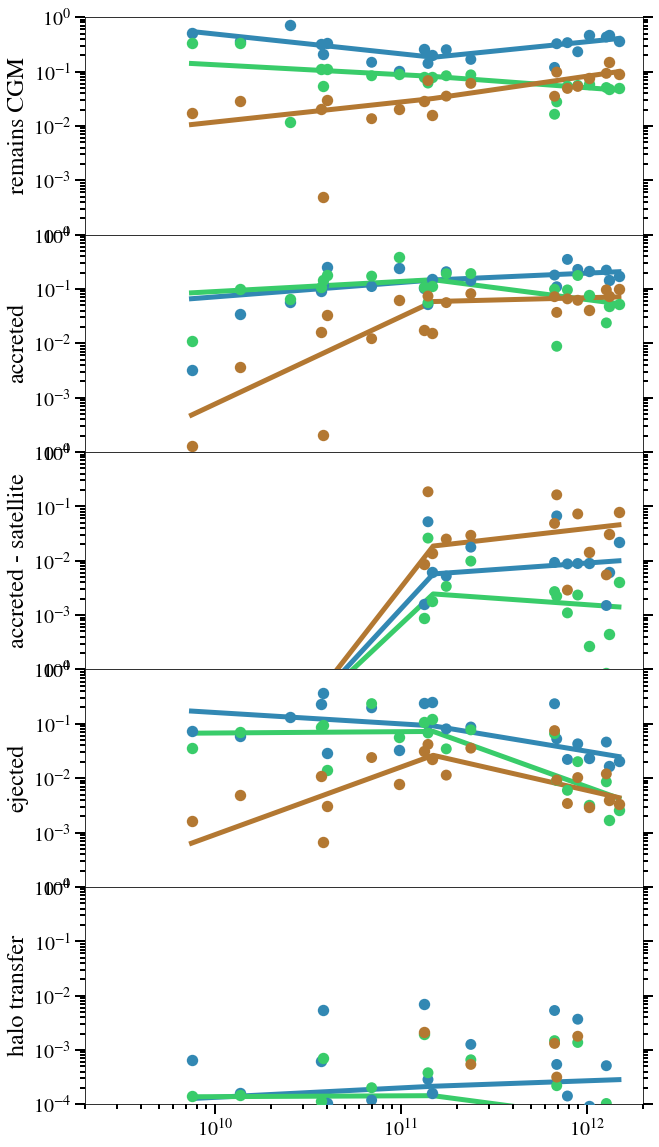

In [33]:
outer_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
inner_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        item = CGM_mass_fractions['joint']['all'][outer_classification][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
            )

        if classification is not None:
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

        # Add a redshift label
        if k == 0:
            redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
            ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

        if snum == 172:
            ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
        ax.set_ylabel( p_constants.CLASSIFICATION_LABELS[outer_classification], fontsize=24 )

        ax.set_xlim( 2e9, 2e12 )
        ax.set_ylim( y_min, y_max )

        ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )

        # Add ticks to the right
        ax.yaxis.set_ticks_position( 'both' )

        if snum == 172:
            legend = ax.legend(
                color_objects,
                labels,
                prop={'size': 17.5},
                ncol=1,
                loc='lower right',
                fontsize=24,
                framealpha = 0.9,
            )
            legend.set_zorder( 120 )
            
fig

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/originfate_mass_frac_vs_Mh_CGM_snum465.pdf


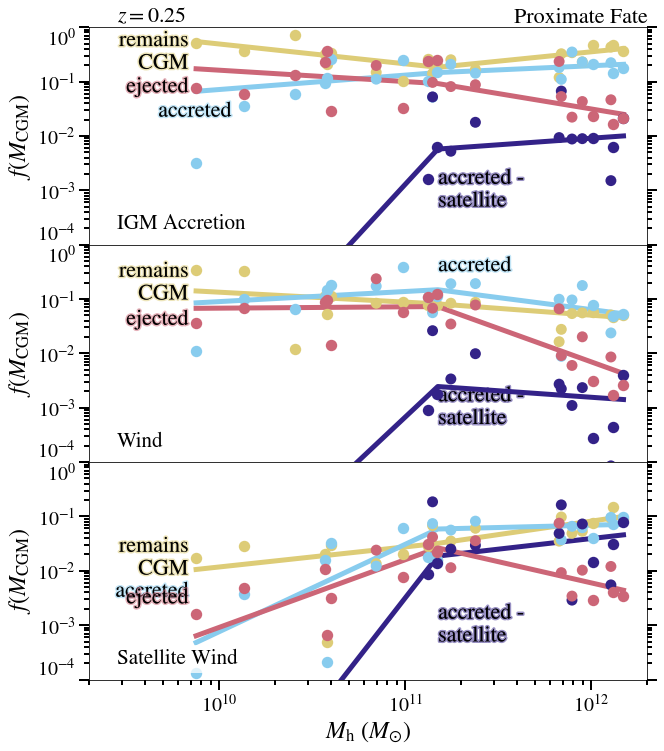

In [35]:
inner_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
outer_classifications = copy.deepcopy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
outer_classifications.remove( 'is_CGM_satellite_ISM' )

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

color_objects = []
for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
            continue
        
        item = CGM_mass_fractions['joint']['all'][classification][outer_classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            means = plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
                return_means = True
            )

        if classification is not None and classification in inner_classifications and ax.is_first_row():
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
            
        ## Annotate lines   
        
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_CGM_accreted':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][0] *= 1.7
                label_args['xy'][1] *= 0.3
            elif outer_classification == 'is_CGM_wind' and snum == 465:
                label_args['xy'] = [ 1.5*1e11, 0.4 ]
                label_args['ha'] = 'left'
            elif outer_classification == 'is_CGM_satellite_wind':
                label_args['xy'][1] *= 1.1
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 1e-3 ]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                if outer_classification == 'is_CGM_wind':
                    label_args['xy'][1] *= 1.75
            if snum == 172:
                label_args['xy'][1] = 3e-4
        elif classification == 'is_CGM_ejected':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][1] *= 0.6
            elif outer_classification == 'is_CGM_wind':
                if snum == 465:
                    label_args['xy'][1] *= 0.6
                elif snum == 172:
                    label_args['xy'][1] *= 0.7

        text = ax.annotate( **label_args )

        text.set_path_effects([
            path_effects.Stroke(
                linewidth=3, 
                foreground=l_config.COLORSCHEME[classification],
                alpha = 0.5,
            ),
            path_effects.Normal(),
        ])

    # Add a redshift label
    if ax.is_first_row():
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.), xycoords='axes fraction', va='bottom', fontsize=22 )

    # Classification Labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = p_constants.CLASSIFICATION_LABELS[outer_classification],
        xy = ( 0.05, 0.05 ),
        xycoords = 'axes fraction',
        fontsize = 21,
        ha = 'left',
        va = 'bottom',
        zorder = 200,
        bbox = bbox_props,
    )
    
    # Axes Labels
    if ax.is_last_row():
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'$f(M_{\rm CGM})$', fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( 1e-4, 1 )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )

    # Avoid overlapping ticks
    ax.get_yticklabels()[1].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-2].set_verticalalignment( 'top' )
    
    # Add ticks to the right
    ax.yaxis.set_ticks_position( 'both' )

    if ax.is_first_row():
        ax.annotate(
            s = 'Proximate Fate',
            xy = ( 1., 1. ),
            va = 'bottom',
            ha = 'right',
            xycoords = 'axes fraction',
            fontsize = 22,
        )
        
save_file = 'originfate_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

# Quantitative Values for the Paper

In [35]:
import os

import py2tex.py2tex as py2tex

In [36]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [37]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [38]:
# Used for variable names
tex_redshift = {
    465: 'low',
    172: 'high',
}

In [39]:
tex_mass = {
    'M': 'mass',
    'enriched_metal_mass': 'metalmass',
}

In [40]:
tex_tag = '{}{}'.format( tex_mass[mass_key], tex_redshift[snum] )
tex_tag

'masslow'

## Load the Origins Data

In [41]:
origins_file_manager = file_management.FileManager( project='CGM_origin' )
mass_budget_data_filepath = os.path.join(
    origins_file_manager.project_parameters['output_data_dir'],
    'halo_mass_content_FIRE2_snum{}.hdf5'.format( snum ),
)
origins_mass_frac_data_filepath = os.path.join(
    origins_file_manager.project_parameters['output_data_dir'],
    'cgm_origins_mass_frac_snum{}.hdf5'.format( snum ),
)

In [42]:
mass_budgets, attributes = verdict.Dict.from_hdf5(
    mass_budget_data_filepath,
    unpack = True,
)
CGM_mass_fracs_origins, attributes = verdict.Dict.from_hdf5(
    origins_mass_frac_data_filepath,
    unpack = True,
)

## Ejected

In [43]:
med_mass_frac = np.median(
    CGM_mass_fractions['fate']['is_CGM_ejected'].split_by_dict( l_config.MASS_BINS )['m12'].array()
)
tex_file.save_variable(
    'percentejectedMW{}'.format( tex_tag ),
    py2tex.to_tex_percentage( med_mass_frac, 5, nearest_base=True )
)

KeyError: 'is_CGM_ejected'

### Dependence on Origins

In [ ]:
frac_cat = (
    CGM_mass_fractions['joint']['is_CGM_ejected']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_IGM_accretion']
)
tex_file.save_variable(
    'percentIGMaccejectedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentIGMaccejectedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat.nanpercentile( 84. ), 5, nearest_base=True )
)

## Accreted

In [ ]:
minish_mass_low = np.percentile( CGM_mass_fractions['fate']['is_CGM_accreted'].array(), 10 )

tex_file.save_variable(
    'percentaccretedmin{}'.format( tex_tag ),
    py2tex.to_tex_percentage( minish_mass_low, 5, nearest_base=True )
)

### Compare Accreted Mass to Galaxy Mass

In [ ]:
accreted_mass = CGM_mass_fractions['fate']['is_CGM_accreted'] * mass_budgets['M']['gas']['m_cgm']
acc_div_gal = accreted_mass / mass_budgets['M']['total']['m_gal']

In [ ]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

ax.scatter(
    halo_masses.array(),
    acc_div_gal.array(),
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

fig

In [ ]:
tex_file.save_variable(
    'accdivgalmedian{}'.format( tex_tag ),
    '{:.2g}'.format( np.median( acc_div_gal.array() ) ),
)

In [ ]:
CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_IGM_accretion']

### Dependence on Origins

#### Fraction of different origins accreted

In [ ]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['is_CGM_accreted']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_IGM_accretion']
)
tex_file.save_variable(
    'percentIGMaccaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentIGMaccaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

In [ ]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['is_CGM_accreted']['is_CGM_wind'] /
    CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_wind']
)
tex_file.save_variable(
    'percentwindaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentwindaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

In [ ]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['is_CGM_accreted']['is_CGM_satellite_wind'] /
    CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_satellite_wind']
)
tex_file.save_variable(
    'percentsatwindaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentsatwindaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

#### Fraction of accreted from different origins

In [ ]:
frac_acc_IGM_acc = (
    CGM_mass_fractions['joint']['is_CGM_accreted']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['fate']['is_CGM_accreted']
)

tex_file.save_variable(
    'percentaccretedIGMaccminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_acc_IGM_acc.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentaccretedIGMaccplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_acc_IGM_acc.nanpercentile( 84. ), 5, nearest_base=True )
)

## Accreted to Satellite

In [ ]:
max_acc_sat = CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'].keymax()
max_acc_sat

In [ ]:
tex_file.save_variable(
    'accsatmax{}'.format( tex_tag ),
    py2tex.to_tex_percentage( max_acc_sat[1], 5, nearest_base=True )
)

### Dependence on Origins

In [ ]:
frac = (
    CGM_mass_fractions['joint']['is_CGM_accreted_to_satellite']['is_CGM_satellite_wind'] /
    CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite']
)

tex_file.save_variable(
    'percentaccsatsatwindminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentaccsatsatwindplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanpercentile( 84. ), 5, nearest_base=True )
)
tex_file.save_variable(
    'percentaccsatsatwindmed{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanmedian(), 5, nearest_base=True )
)

### Comparison to Satellite Mass

In [ ]:
CGM_mass_fractions['joint']['is_in_CGM_not_sat']['is_CGM_satellite_ISM']

In [ ]:
acc_sat_to_sat = (
    CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'] /
    CGM_mass_fractions['fate']['is_CGM_satellite_ISM']
)
acc_sat_to_sat

In [ ]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

ax.scatter(
    CGM_mass_fractions['fate']['is_CGM_satellite_ISM'].array(),
    CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'].array(),
)

# Line
sat_masses = np.logspace( -4., 1., 256 )
possible_slope = np.nanmedian(
    (
        CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'] /
        CGM_mass_fractions['fate']['is_CGM_satellite_ISM']
    ).array()
)
acc_sat_masses = (
    possible_slope * (
        sat_masses - np.median( CGM_mass_fractions['fate']['is_CGM_satellite_ISM'].array() )
    ) +
    np.median( CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'].array() )
)

ax.plot(
    sat_masses,
    acc_sat_masses
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

arr = CGM_mass_fractions['fate']['is_CGM_satellite_ISM'].array()
x_min = np.nanmin( arr[arr>0.] )*0.9
arr = CGM_mass_fractions['fate']['is_CGM_accreted_to_satellite'].array()
y_min = np.nanmin( arr[arr>0.] )*0.9

ax.set_xlim( x_min, 1., )
ax.set_ylim( y_min, 1., )

fig

## Halo Transfer

In [ ]:
CGM_mass_fractions['fate']['is_CGM_halo_transfer'].keymax()

## Still CGM

In [ ]:
p = CGM_mass_fractions['fate']['is_CGM_still'].nanpercentile( 16 )

tex_file.save_variable(
    'stillCGMmed{}'.format( tex_tag ),
    py2tex.to_tex_percentage( p, 10, nearest_base=True )
)